In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt


from filters.kalman_filter import SimplestKalmanFilter1D
from simulations.stochastic_models import StochasticModels

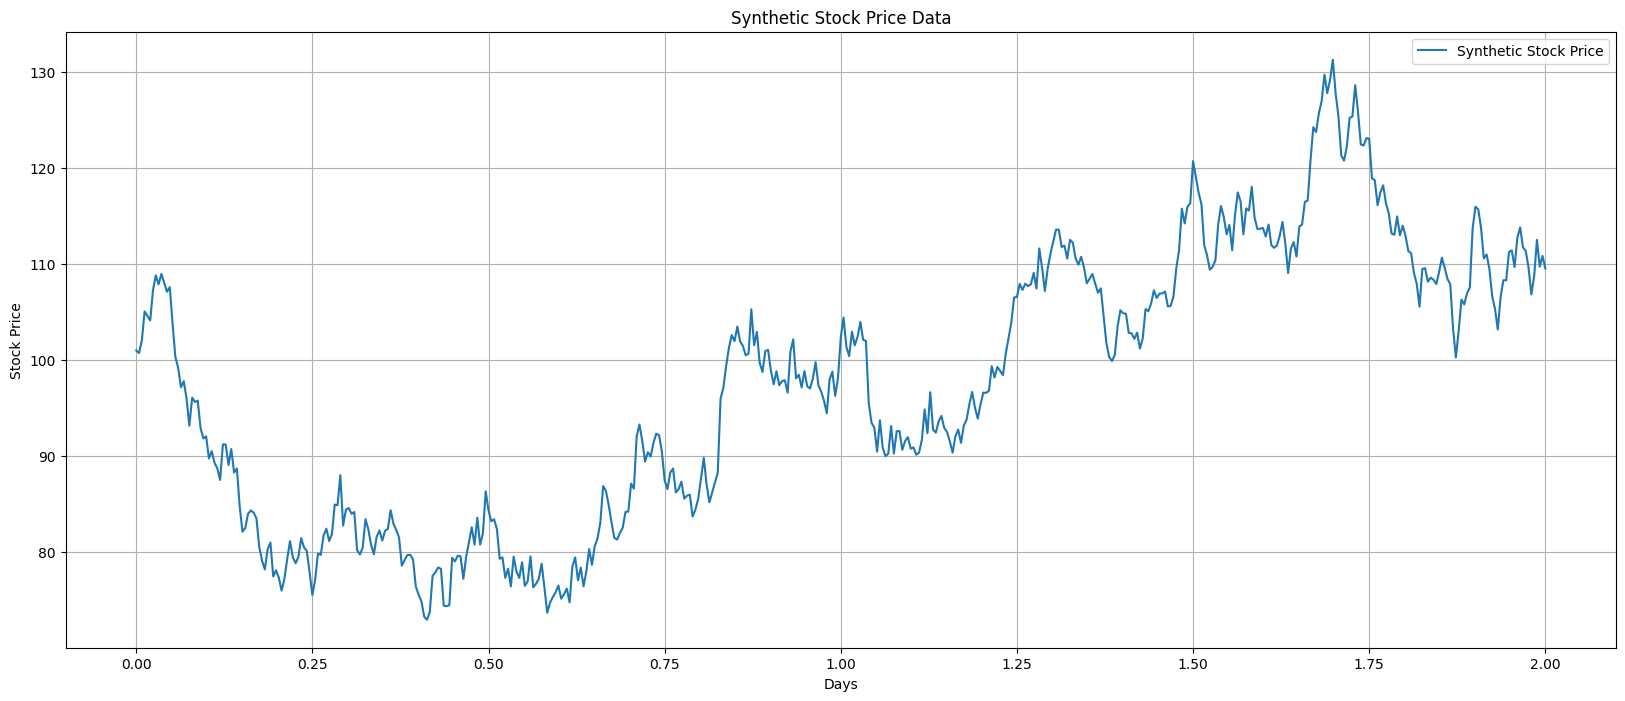

In [2]:
# Seed for reproducibility
np.random.seed(42)

# Number of days for our synthetic stock data
num_days = 250


t, prices = StochasticModels.simulate_random_walk_process(2,100)

# Plot the synthetic stock price data
plt.figure(figsize=(20, 8))
plt.plot(t,prices, label="Synthetic Stock Price")
plt.title("Synthetic Stock Price Data")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Kalman & estimation

The SSM here of the Kalman filter is given by:

$$
\begin{cases}
    x_t = Ax_{t-1} + w_t \\
    y_t = Cx_t + v_t
\end{cases}
$$

Where :

- $x_t$ is the state vector of dimension $1$ at time $t$ is contains the price of the asset
- $y_t$ is the observation vector of dimension $1$ at time $t$ is contains the price of the asset since we observe the price of the asset and there are not unit conversion.
- $A$ and $C$ are the matrices of the model here $A = 1$ and $C = 1$.

Then :

$$
\begin{cases}
    x_t = x_{t-1} + w_t \\
    y_t = x_t + v_t
\end{cases}
$$


In [5]:
# Parameters for our Kalman filter
Q = 1  # Process noise variance (assumption)
R = 4  # Measurement noise variance (based on our synthetic data generation)

# Create and run the Kalman filter
kf = SimplestKalmanFilter1D(Q, R)
price_hat, _ = kf.fit_predict(prices, verbose=False)

Kalman Filter Progress: 100%|██████████| 504/504 [00:00<00:00, 230426.12it/s]


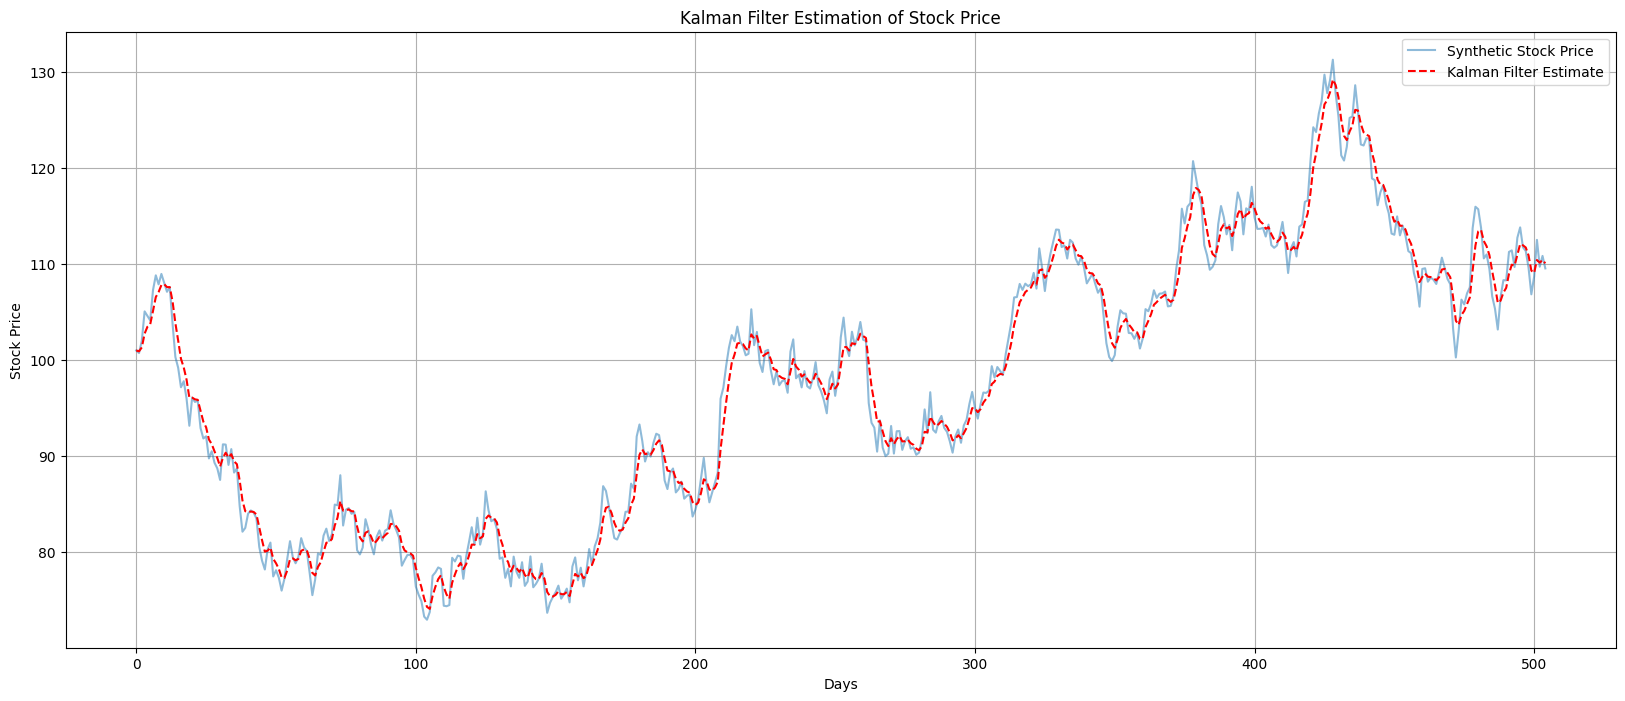

In [6]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(prices, label="Synthetic Stock Price", alpha=0.5)
plt.plot(price_hat, label="Kalman Filter Estimate", linestyle="--", color="red")
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

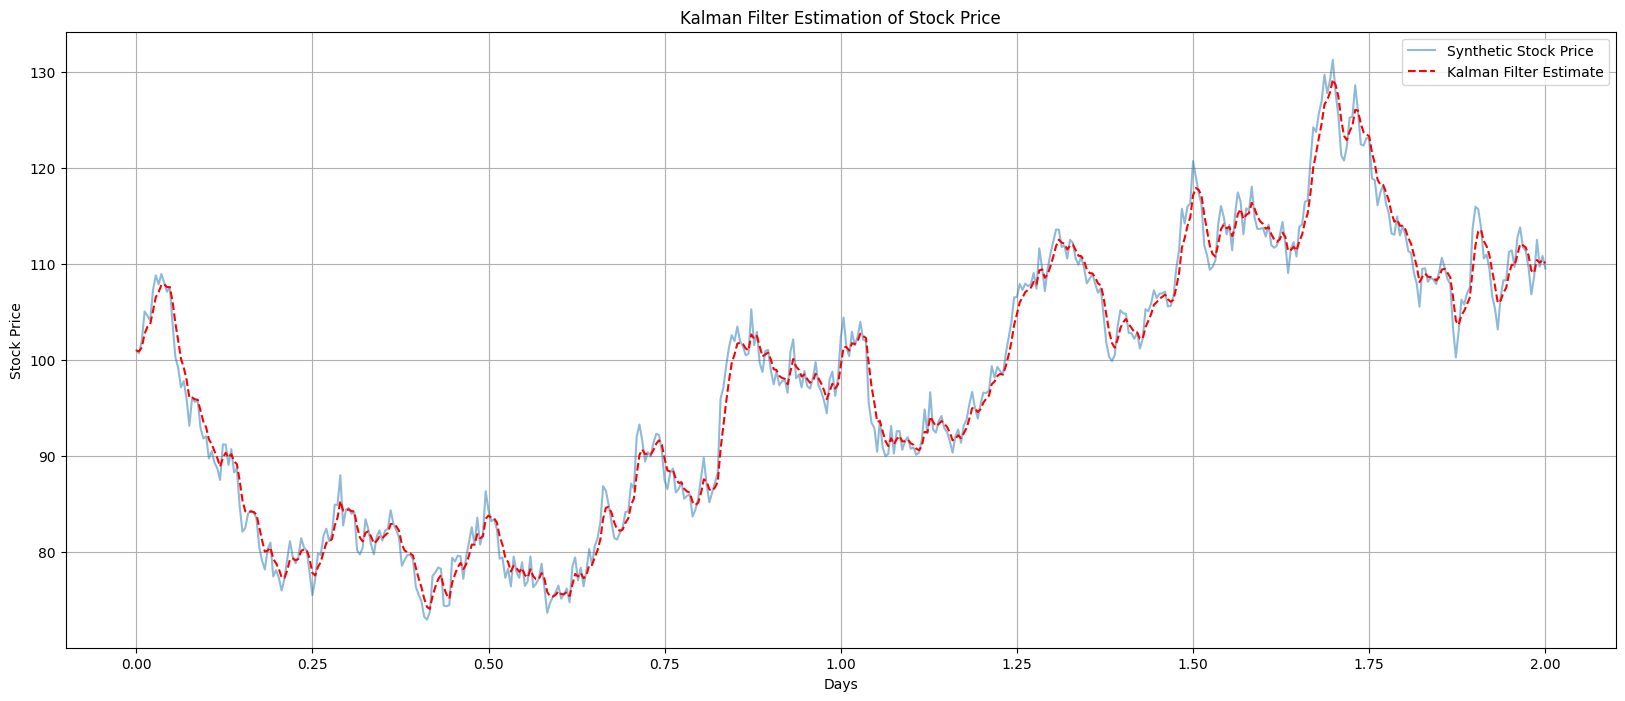

In [7]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(t, prices, label="Synthetic Stock Price", alpha=0.5)
plt.plot(t,price_hat, label="Kalman Filter Estimate", linestyle="--", color="red")
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()